In [6]:
import sys
import os
sys.path.append(os.path.abspath('..'))
from infrastructure.utils import calculate_coeffs, calculate_loss_function, plot_decoding
from infrastructure.DelayNetwork import DelayNetwork
import numpy as np
import nengo
import matplotlib.pyplot as plt

In [7]:
np.random.seed(42)
dt=0.001
run_time = 10.0
readout_synapse = 0.05
inp_high = 10
neuron_type = nengo.AdaptiveLIF(tau_n=0.5, inc_n=0.01)
delay_mode = "zero"
n_neurons = 300

In [8]:
with nengo.Network(seed=10) as model:
    white_signal = nengo.processes.WhiteSignal(period=run_time, high=10, rms=0.25, seed=121)
    input_node = nengo.Node(white_signal, size_out=1)
    delay_network = DelayNetwork(num_neurons=n_neurons, readout_synapse=readout_synapse, neuron_type=neuron_type, delay_mode=delay_mode)
    nengo.Connection(input_node, delay_network.ens, synapse=None)

    p_input = nengo.Probe(input_node, sample_every=dt)
    p_delay_activity = nengo.Probe(delay_network.readout, synapse=None, sample_every=dt)
    
with nengo.Simulator(model) as sim:
    sim.run(run_time)

delay_coeffs = calculate_coeffs(sim.data[p_delay_activity], sim.data[p_input])

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

In [9]:
with nengo.Network(seed=10) as model:
    white_signal = nengo.processes.WhiteSignal(period=run_time, high=10, rms=0.25, seed=223)
    input_node = nengo.Node(white_signal, size_out=1)
    delay_network = DelayNetwork(num_neurons=n_neurons, decoder_weights=delay_coeffs, readout_synapse=readout_synapse, neuron_type=neuron_type, delay_mode=delay_mode)
    nengo.Connection(input_node, delay_network.ens, synapse=None)

    p_input = nengo.Probe(input_node, sample_every=dt)
    p_delay_decoded = nengo.Probe(delay_network.readout, synapse=None, sample_every=dt)
    p_nengo_decoded = nengo.Probe(delay_network.nengo_readout, synapse=None, sample_every=dt)

with nengo.Simulator(model) as sim:
    sim.run(run_time)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

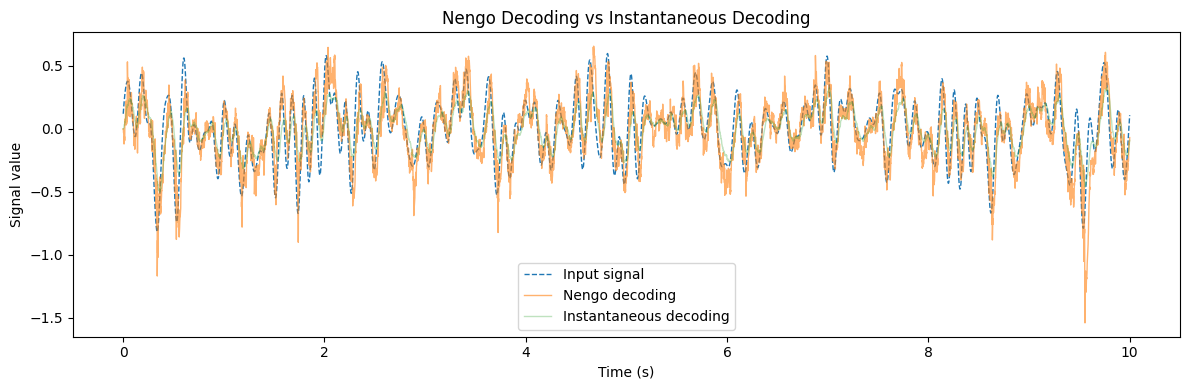

Instantaneous Decoding Loss:  0.02701358469414884
Nengo Decoding Loss:  0.028784297463720354


In [10]:
plt.figure(figsize=(12, 4))
plt.plot(sim.trange(), sim.data[p_input], label="Input signal", linewidth=1, linestyle='--')
plt.plot(sim.trange(), sim.data[p_delay_decoded], label="Nengo decoding", linewidth=1, alpha=0.6)
plt.plot(sim.trange(), sim.data[p_nengo_decoded], label="Instantaneous decoding", linewidth=1, alpha=0.3)

plt.xlabel("Time (s)")
plt.ylabel("Signal value")
plt.title('Nengo Decoding vs Instantaneous Decoding')
plt.legend()
plt.tight_layout()
plt.show()
print('Instantaneous Decoding Loss: ', calculate_loss_function(sim.data[p_input], sim.data[p_delay_decoded]))
print('Nengo Decoding Loss: ', calculate_loss_function(sim.data[p_input], sim.data[p_nengo_decoded]))